# Richter's Predictor Project

In this project, I will be working on predicting the levels of damage to a building (1 - low, 2 - medium, 3 - high) caused by the 2015 Gorkha Earthquake in Nepal. 

In [93]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

### **STEP 1**: Exploratory Data Analysis

In [94]:
# reading the training features dataset and printing it out
train_set_features = pd.read_excel("Train_Features.xlsx")

# seperate the column names based on the comma
new_columns = []
new_columns = train_set_features.columns[0].split(',')


#seperate the row names on the comma
values = []
for col in train_set_features.columns:
    for row in train_set_features[col]:
        if isinstance(row, str):  # Check if the value is a string
            values.append(row.split(','))  # Split string values by commas
        else:
            values.append([row])  # If it's not a string, just keep it as is

clean_train_set_features = pd.DataFrame(values,columns = new_columns) # creates new clean dataframe
clean_train_set_features.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [95]:
clean_train_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  object
 1   geo_level_1_id                          260601 non-null  object
 2   geo_level_2_id                          260601 non-null  object
 3   geo_level_3_id                          260601 non-null  object
 4   count_floors_pre_eq                     260601 non-null  object
 5   age                                     260601 non-null  object
 6   area_percentage                         260601 non-null  object
 7   height_percentage                       260601 non-null  object
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [96]:
# reading the train labels dataset and printing it out
train_set_labels = pd.read_excel("Train_labels.xlsx")

# seperate the column names based on the comma
new_columns = []
new_columns = train_set_labels.columns[0].split(',')


#seperate the row names on the comma
values = []
for col in train_set_labels.columns:
    for row in train_set_labels[col]:
        if isinstance(row, str):  # Check if the value is a string
            values.append(row.split(','))  # Split string values by commas
        else:
            values.append([row])  # If it's not a string, just keep it as is

clean_train_set_labels = pd.DataFrame(values,columns = new_columns) # creates new clean dataframe
clean_train_set_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [97]:
clean_train_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   building_id   260601 non-null  object
 1   damage_grade  260601 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB


In [98]:
# reading the test features dataset and printing it out
test_set_features = pd.read_excel("test_features.xlsx")

# seperate the column names based on the comma
new_columns = []
new_columns = test_set_features.columns[0].split(',')

#seperate the row names on the comma
values = []
for col in test_set_features.columns:
    for row in test_set_features[col]:
        if isinstance(row, str):  # Check if the value is a string
            values.append(row.split(','))  # Split string values by commas
        else:
            values.append([row])  # If it's not a string, just keep it as is

clean_test_set_features = pd.DataFrame(values,columns = new_columns) # creates new clean dataframe
clean_test_set_features.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


**Step 2**: Data cleaning and preprocessing

*PART A- checking for any null/missing and any duplicated values*

In [99]:
clean_train_set_features.isna().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [100]:
clean_train_set_features.duplicated().sum()

0

In [101]:
clean_train_set_labels.isna().sum()

building_id     0
damage_grade    0
dtype: int64

In [102]:
clean_train_set_labels.duplicated().sum()

0

In [103]:
clean_test_set_features.isna().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [104]:
clean_test_set_features.duplicated().sum()

0

*PART B - Assigning the correct datatype to each column*

In [105]:
# working with train labels column first
clean_train_set_labels["building_id"] = clean_train_set_labels["building_id"].astype(int)
clean_train_set_labels["damage_grade"] = clean_train_set_labels["damage_grade"].astype(int)
clean_train_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   building_id   260601 non-null  int64
 1   damage_grade  260601 non-null  int64
dtypes: int64(2)
memory usage: 4.0 MB


In [106]:
#helper method that checks whether a value could be safely converted to an int 
# or not

def safe_convert(value):
    try:
        return int(value) # return the converted value
    except ValueError:
        return value  # return original value


In [107]:
#working with train features columns
column_names = clean_train_set_features.columns

for col in column_names:
    for row in range(len(col)):
        value = clean_train_set_features[col][row]
        check_value = safe_convert(value)
        if(isinstance(check_value,int)):
            clean_train_set_features[col] = clean_train_set_features[col].astype(int)
        elif(isinstance(check_value,float)):
            clean_train_set_features[col] = clean_train_set_features[col].astype(float)
        else:
            clean_train_set_features[col] = clean_train_set_features[col].astype(str)

print(clean_train_set_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [108]:
# converting percentage columns into float

# Update the values directly in the DataFrame
if "area_percentage" in clean_train_set_features.columns:
    clean_train_set_features["area_percentage"] /= 100.0
if "height_percentage" in clean_train_set_features.columns:
    clean_train_set_features["height_percentage"] /= 100.0

clean_train_set_features["area_percentage"] = clean_train_set_features["area_percentage"].astype(float)
clean_train_set_features["height_percentage"] = clean_train_set_features["height_percentage"].astype(float)

In [109]:
clean_train_set_features

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,0.06,0.05,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,0.08,0.07,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,0.05,0.05,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,0.06,0.05,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,0.08,0.09,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,0.06,0.03,n,r,...,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,0.06,0.05,t,r,...,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,0.06,0.07,t,r,...,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,0.14,0.06,t,r,...,0,0,0,0,0,0,0,0,0,0


In [110]:
#working with test feature columns
column_names = clean_test_set_features.columns

for col in column_names:
    for row in range(len(col)):
        value = clean_test_set_features[col][row]
        check_value = safe_convert(value)
        if(isinstance(check_value,int)):
            clean_test_set_features[col] = clean_test_set_features[col].astype(int)
        elif(isinstance(check_value,float)):
            clean_test_set_features[col] = clean_test_set_features[col].astype(float)
        else:
            clean_test_set_features[col] = clean_test_set_features[col].astype(str)

print(clean_test_set_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int64 
 5   age                                     86868 non-null  int64 
 6   area_percentage                         86868 non-null  int64 
 7   height_percentage                       86868 non-null  int64 
 8   land_surface_condition                  86868 non-null  object
 9   foundation_type                         86868 non-null  object
 10  roof_type                               86868 non-null  object
 11  gr

In [111]:
# converting percentage columns into float

# Update the values directly in the DataFrame
if "area_percentage" in clean_test_set_features.columns:
    clean_test_set_features["area_percentage"] /= 100.0
if "height_percentage" in clean_test_set_features.columns:
    clean_test_set_features["height_percentage"] /= 100.0

clean_test_set_features["area_percentage"] = clean_test_set_features["area_percentage"].astype(float)
clean_test_set_features["height_percentage"] = clean_test_set_features["height_percentage"].astype(float)

In [112]:
clean_test_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   geo_level_1_id                          86868 non-null  int64  
 2   geo_level_2_id                          86868 non-null  int64  
 3   geo_level_3_id                          86868 non-null  int64  
 4   count_floors_pre_eq                     86868 non-null  int64  
 5   age                                     86868 non-null  int64  
 6   area_percentage                         86868 non-null  float64
 7   height_percentage                       86868 non-null  float64
 8   land_surface_condition                  86868 non-null  object 
 9   foundation_type                         86868 non-null  object 
 10  roof_type                               86868 non-null  ob

In [113]:
clean_test_set_features.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,0.07,0.06,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,0.13,0.05,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,0.04,0.05,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,0.19,0.03,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,0.08,0.07,t,r,...,0,0,0,0,0,0,0,0,0,0


*PART C - One-hot encoding*

In [114]:
# using get dummies function to convert categorical columns into one-hot encoded columns

# Select non-numeric columns
non_numeric_cols = clean_test_set_features.select_dtypes(exclude=['int','float']).columns

# Apply get_dummies to those columns
clean_test_set_features = pd.get_dummies(clean_test_set_features, columns=non_numeric_cols)

for col in clean_test_set_features.columns:
    if(clean_test_set_features[col].dtype == "bool"):
        clean_test_set_features[col] = clean_test_set_features[col].astype(int)

clean_test_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   geo_level_1_id                          86868 non-null  int64  
 2   geo_level_2_id                          86868 non-null  int64  
 3   geo_level_3_id                          86868 non-null  int64  
 4   count_floors_pre_eq                     86868 non-null  int64  
 5   age                                     86868 non-null  int64  
 6   area_percentage                         86868 non-null  float64
 7   height_percentage                       86868 non-null  float64
 8   has_superstructure_adobe_mud            86868 non-null  int64  
 9   has_superstructure_mud_mortar_stone     86868 non-null  int64  
 10  has_superstructure_stone_flag           86868 non-null  in

In [115]:
clean_test_set_features

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,17,596,11307,3,20,0.07,0.06,0,1,...,0,0,0,0,0,0,0,0,1,0
1,99355,6,141,11987,2,25,0.13,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
2,890251,22,19,10044,2,5,0.04,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
3,745817,26,39,633,1,0,0.19,0.03,0,0,...,0,0,0,0,0,0,0,0,1,0
4,421793,17,289,7970,3,15,0.08,0.07,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,0.20,0.06,0,1,...,0,0,0,0,0,0,0,0,0,1
86864,663567,10,1407,11907,3,25,0.06,0.07,1,1,...,0,0,0,0,0,0,0,0,1,0
86865,1049160,22,1136,7712,1,50,0.03,0.03,0,1,...,0,0,0,0,0,0,0,0,1,0
86866,442785,6,1041,912,2,5,0.09,0.05,1,1,...,0,0,0,0,0,0,1,0,0,0


In [116]:
# doing the same one-hot enconding for training feature columns

# Select non-numeric columns
non_numeric_cols = clean_train_set_features.select_dtypes(exclude=['int','float']).columns

# Apply get_dummies to those columns
clean_train_set_features = pd.get_dummies(clean_train_set_features, columns=non_numeric_cols)

one_hot_col_names = []

for col in clean_train_set_features.columns:
    if(clean_train_set_features[col].dtype == "bool"):
        one_hot_col_names.append(col)
        clean_train_set_features[col] = clean_train_set_features[col].astype(int)
clean_train_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 69 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   geo_level_1_id                          260601 non-null  int64  
 2   geo_level_2_id                          260601 non-null  int64  
 3   geo_level_3_id                          260601 non-null  int64  
 4   count_floors_pre_eq                     260601 non-null  int64  
 5   age                                     260601 non-null  int64  
 6   area_percentage                         260601 non-null  float64
 7   height_percentage                       260601 non-null  float64
 8   has_superstructure_adobe_mud            260601 non-null  int64  
 9   has_superstructure_mud_mortar_stone     260601 non-null  int64  
 10  has_superstructure_stone_flag           2606

In [117]:
clean_train_set_features

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,2,30,0.06,0.05,1,1,...,0,0,0,0,0,0,0,0,1,0
1,28830,8,900,2812,2,10,0.08,0.07,0,1,...,0,0,0,0,0,0,0,0,1,0
2,94947,21,363,8973,2,10,0.05,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
3,590882,22,418,10694,2,10,0.06,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
4,201944,11,131,1488,3,30,0.08,0.09,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,0.06,0.03,0,1,...,0,0,0,1,0,0,0,0,1,0
260597,669485,17,715,2060,2,0,0.06,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
260598,602512,17,51,8163,3,55,0.06,0.07,0,1,...,0,0,0,0,0,0,0,0,1,0
260599,151409,26,39,1851,2,10,0.14,0.06,0,0,...,0,0,0,0,0,0,0,0,1,0


In [118]:
clean_test_set_features

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,17,596,11307,3,20,0.07,0.06,0,1,...,0,0,0,0,0,0,0,0,1,0
1,99355,6,141,11987,2,25,0.13,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
2,890251,22,19,10044,2,5,0.04,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
3,745817,26,39,633,1,0,0.19,0.03,0,0,...,0,0,0,0,0,0,0,0,1,0
4,421793,17,289,7970,3,15,0.08,0.07,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,0.20,0.06,0,1,...,0,0,0,0,0,0,0,0,0,1
86864,663567,10,1407,11907,3,25,0.06,0.07,1,1,...,0,0,0,0,0,0,0,0,1,0
86865,1049160,22,1136,7712,1,50,0.03,0.03,0,1,...,0,0,0,0,0,0,0,0,1,0
86866,442785,6,1041,912,2,5,0.09,0.05,1,1,...,0,0,0,0,0,0,1,0,0,0


### **STEP 2**: Data visualization

In [119]:
# adding label columns to the training features to create the complete training set

clean_train_frame = clean_train_set_features.copy() # creates copy of training feature dataframe
clean_train_frame["damage_grade"] = clean_train_set_labels["damage_grade"] # added label column to the dataframe
clean_train_frame # complete training set

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
0,802906,6,487,12198,2,30,0.06,0.05,1,1,...,0,0,0,0,0,0,0,1,0,3
1,28830,8,900,2812,2,10,0.08,0.07,0,1,...,0,0,0,0,0,0,0,1,0,2
2,94947,21,363,8973,2,10,0.05,0.05,0,1,...,0,0,0,0,0,0,0,1,0,3
3,590882,22,418,10694,2,10,0.06,0.05,0,1,...,0,0,0,0,0,0,0,1,0,2
4,201944,11,131,1488,3,30,0.08,0.09,1,0,...,0,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,0.06,0.03,0,1,...,0,0,1,0,0,0,0,1,0,2
260597,669485,17,715,2060,2,0,0.06,0.05,0,1,...,0,0,0,0,0,0,0,1,0,3
260598,602512,17,51,8163,3,55,0.06,0.07,0,1,...,0,0,0,0,0,0,0,1,0,3
260599,151409,26,39,1851,2,10,0.14,0.06,0,0,...,0,0,0,0,0,0,0,1,0,2


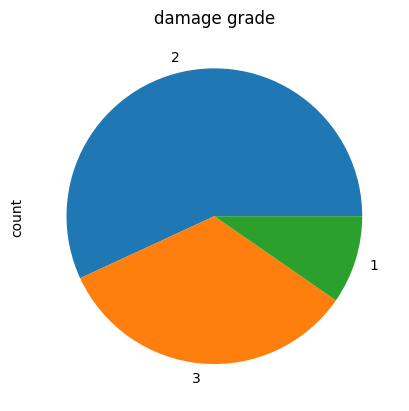

In [120]:
# creating pie chart to check how the classes are distributed
count_classes = clean_train_frame["damage_grade"].value_counts()
count_classes.plot(kind = "pie")
plt.title("damage grade")
plt.show()

*The pie chart above shows significant class imbalance, with 2 and 3 dominating
the dataset.*

In [121]:
print(one_hot_col_names)

['land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t', 'foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w', 'roof_type_n', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f', 'ground_floor_type_m', 'ground_floor_type_v', 'ground_floor_type_x', 'ground_floor_type_z', 'other_floor_type_j', 'other_floor_type_q', 'other_floor_type_s', 'other_floor_type_x', 'position_j', 'position_o', 'position_s', 'position_t', 'plan_configuration_a', 'plan_configuration_c', 'plan_configuration_d', 'plan_configuration_f', 'plan_configuration_m', 'plan_configuration_n', 'plan_configuration_o', 'plan_configuration_q', 'plan_configuration_s', 'plan_configuration_u', 'legal_ownership_status_a', 'legal_ownership_status_r', 'legal_ownership_status_v', 'legal_ownership_status_w']


In [122]:
# creating mutual information to see how my features are related to my 
# target variable
# Higher mutual information indicates strong correlation 
# Lower mutual information indicates weak correlation

label = clean_train_frame[["damage_grade"]] # selects damage_grade (label) column
features = clean_train_frame.drop(columns = "damage_grade")
mi = mutual_info_classif(features,label)

# creating the mutual information dataframe 
mi_df = pd.DataFrame({'Feature': features.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

mi_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,Mutual Information
3,geo_level_3_id,0.296535
2,geo_level_2_id,0.234119
1,geo_level_1_id,0.132935
36,foundation_type_r,0.089333
9,has_superstructure_mud_mortar_stone,0.076511
...,...,...
28,has_secondary_use_gov_office,0.000000
30,has_secondary_use_other,0.000000
32,land_surface_condition_o,0.000000
55,plan_configuration_a,0.000000


*There are some columns at the bottom that have a **mutual information** of 0, this
means that there is **NO** correlation between the feature and the target. These
columns will be dropped since they won't be relevant to our model*

In [123]:
for i, col in enumerate(features.columns):
    if mi[i] == 0:
        clean_train_frame.drop(col, axis=1, inplace=True)  # Drop the column with zero mutual info
clean_train_frame.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_v,legal_ownership_status_w,damage_grade
0,802906,6,487,12198,2,30,0.06,0.05,1,1,...,0,0,0,0,0,0,0,1,0,3
1,28830,8,900,2812,2,10,0.08,0.07,0,1,...,0,0,0,0,0,0,0,1,0,2
2,94947,21,363,8973,2,10,0.05,0.05,0,1,...,0,0,0,0,0,0,0,1,0,3
3,590882,22,418,10694,2,10,0.06,0.05,0,1,...,0,0,0,0,0,0,0,1,0,2
4,201944,11,131,1488,3,30,0.08,0.09,1,0,...,0,0,0,0,0,0,0,1,0,3


In [124]:
clean_test_set_features.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,17,596,11307,3,20,0.07,0.06,0,1,...,0,0,0,0,0,0,0,0,1,0
1,99355,6,141,11987,2,25,0.13,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
2,890251,22,19,10044,2,5,0.04,0.05,0,1,...,0,0,0,0,0,0,0,0,1,0
3,745817,26,39,633,1,0,0.19,0.03,0,0,...,0,0,0,0,0,0,0,0,1,0
4,421793,17,289,7970,3,15,0.08,0.07,0,1,...,0,0,0,0,0,0,0,0,1,0


### **STEP 3**: Model Building

*Due to significant class imbalance in the dataset, we will use models that account for class weights to **prevent** bias towards the majority class. I will implement Balanced Random Forest, XGBoost, and LightGBM, which are well-suited for handling imbalanced classification problems.*

In [125]:
# Create Balanced Random Forest classifier
brf = BalancedRandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42, 
    max_depth=10     
)

In [126]:
# Create XGBoost classifier with imbalance handling

# Total number of samples
total_samples = len(clean_train_frame)

# Number of unique classes
num_classes = clean_train_frame["damage_grade"].nunique() # returns the "number" of unique values

# Calculate class weights 
# weights make sure that each class is given equal weightage
scale_weight = {
    class_i: (total_samples / (num_classes * len(clean_train_frame[clean_train_frame["damage_grade"] == class_i])))
    for class_i in clean_train_frame["damage_grade"].unique() # unique - returns the different unique values
}

xgb = XGBClassifier(
    scale_pos_weight=scale_weight,  #
    use_label_encoder=False,  # Disable unnecessary warnings
    random_state=42        
)

In [127]:
# Create LightGBM classifier
lgbm = lgb.LGBMClassifier(
    class_weight='balanced',  # Automatically handles imbalance
    random_state=42          
)

In [128]:
X = features
y = label.values.ravel()  # Convert target to an array

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the target variable to have labels starting from 0
y_encoded = encoder.fit_transform(y)
y = y_encoded

*Doing **hyperparameter tuning** since the F-1 score was low.*

In [129]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Metrics storage
brf_train_f1_scores = []
brf_val_f1_scores = []
lgb_train_f1_scores = []
lgb_val_f1_scores = []
xgb_train_f1_scores = []
xgb_val_f1_scores = []

# Stratified K-Fold Loop
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Balanced Random Forest
    brf = BalancedRandomForestClassifier(n_estimators=462, max_depth=30)
    brf.fit(X_train, y_train)
    brf_train_preds = brf.predict(X_train)
    brf_val_preds = brf.predict(X_val)
    brf_train_f1_scores.append(f1_score(y_train, brf_train_preds, average='weighted'))
    brf_val_f1_scores.append(f1_score(y_val, brf_val_preds, average='weighted'))
    
    # LightGBM
    lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced',n_estimators=550,num_leaves= 250, learning_rate = 0.04)
    lgb_model.fit(X_train, y_train)
    lgb_train_preds = lgb_model.predict(X_train)
    lgb_val_preds = lgb_model.predict(X_val)
    lgb_train_f1_scores.append(f1_score(y_train, lgb_train_preds, average='weighted'))
    lgb_val_f1_scores.append(f1_score(y_val, lgb_val_preds, average='weighted'))
    
    # XGBoost
    xgb_model = XGBClassifier(random_state=42, scale_pos_weight=1,n_estimators=300,max_depth=8,learning_rate = 0.05)
    xgb_model.fit(X_train, y_train)
    xgb_train_preds = xgb_model.predict(X_train)
    xgb_val_preds = xgb_model.predict(X_val)
    xgb_train_f1_scores.append(f1_score(y_train, xgb_train_preds, average='weighted'))
    xgb_val_f1_scores.append(f1_score(y_val, xgb_val_preds, average='weighted'))

# Average Training and Validation F1 Scores
print("Balanced Random Forest")
print(f"Training F1-Score: {np.mean(brf_train_f1_scores):.4f}")
print(f"Validation F1-Score: {np.mean(brf_val_f1_scores):.4f}")

print("\nLightGBM")
print(f"Training F1-Score: {np.mean(lgb_train_f1_scores):.4f}")
print(f"Validation F1-Score: {np.mean(lgb_val_f1_scores):.4f}")

print("\nXGBoost")
print(f"Training F1-Score: {np.mean(xgb_train_f1_scores):.4f}")
print(f"Validation F1-Score: {np.mean(xgb_val_f1_scores):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 173734, number of used features: 67
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:14:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 173734, number of used features: 67
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 173734, number of used features: 67
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Balanced Random Forest
Training F1-Score: 0.8276
Validation F1-Score: 0.6701

LightGBM
Training F1-Score: 0.8288
Validation F1-Score: 0.7117

XGBoost
Training F1-Score: 0.7519
Validation F1-Score: 0.7135


### **Step 4** - Testing Final Model on **unseen** data

In [135]:
X_test_val = clean_test_set_features.values # test features as a numpy array

xgb_preds_test = xgb_model.predict(X_test_val)

# Adjust predictions (add 1)
xgb_preds_test_adjusted = xgb_preds_test + 1

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'building_id': clean_test_set_features["building_id"],
    'damage_grade': xgb_preds_test_adjusted
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)